## LSTM Sliding Window Technique to predict rotorcraft phase

#### Installation
1) Create conda environment with python 3.9
2) Install following packages
    conda install -c conda-forge pandas
    conda install -c conda-forge numpy
    conda install -c conda-forge scikit-learn
    conda install -c conda-forge jupyter
    conda install -c conda-forge matplotlib
    conda install -c conda-forge seaborn
    conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
3) Install GPU drivers for better speed

#### Notes
The code was run on a GPU equipped machine
With GPU capability, training takes only a few minutes. With CPU, this could take hours

#### About LSTM
Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) designed for handling sequential data.
The rotorcraft data is sequential in nature and LSTM can identify patterns in this type of data well.

In [81]:
import utils

#### Load Training Data
Loads only these columns - 'Vert. Speed', 'Groundspeed', 'Altitude(AGL)', 'Date', 'System UTC Time'

In [82]:
train_csv_directory = 'data/train_data'
selected_df = utils.load_data_from_dir(train_csv_directory)
selected_df.head(10)

reading file data/train_data\SimData_2022.07.28_10.07.30.csv
reading file data/train_data\SimData_2022.07.28_10.11.13.csv
reading file data/train_data\SimData_2022.07.28_10.59.59.csv
reading file data/train_data\SimData_2022.07.28_11.47.45.csv
reading file data/train_data\SimData_2022.07.28_12.16.14.csv
reading file data/train_data\SimData_2022.07.28_13.45.28.csv
reading file data/train_data\SimData_2022.07.28_14.02.12.csv
reading file data/train_data\SimData_2022.07.28_14.19.29.csv
reading file data/train_data\SimData_2022.07.28_14.44.18.csv
reading file data/train_data\SimData_2022.07.28_15.13.02.csv
reading file data/train_data\SimData_2022.07.28_15.57.11.csv
reading file data/train_data\SimData_2022.07.28_16.45.29.csv
reading file data/train_data\SimData_2022.07.28_16.51.43.csv
reading file data/train_data\SimData_2022.07.28_16.59.08.csv
reading file data/train_data\SimData_2022.10.20_12.43.14.csv
reading file data/train_data\SimData_2022.10.20_13.25.49.csv
reading file data/train_

,Vert. Speed,Groundspeed,Altitude(AGL),Date,System UTC Time
1,-0.001,0.041,0.06,07/28/2022,14:07:52.445
2,0.004,0.038,0.06,07/28/2022,14:07:52.467
3,0.008,0.032,0.06,07/28/2022,14:07:52.485
4,0.011,0.019,0.06,07/28/2022,14:07:52.523
5,0.013,0.010,0.06,07/28/2022,14:07:52.546
6,0.015,0.004,0.06,07/28/2022,14:07:52.569
7,0.016,0.008,0.06,07/28/2022,14:07:52.593
8,0.018,0.012,0.06,07/28/2022,14:07:52.616
9,0.019,0.014,0.06,07/28/2022,14:07:52.639
10,0.021,0.013,0.06,07/28/2022,14:07:52.663


In [83]:
print('column data types')
selected_df.dtypes

column data types


Vert. Speed        object
Groundspeed        object
Altitude(AGL)      object
Date               object
System UTC Time    object
dtype: object

#### Formatting involves
a) Combine Date and Time column and change type to datetime
b) Convert columns to float - 'Vert. Speed', 'Groundspeed', 'Altitude(AGL)'
c) Sort by datetime so LSTM sequences are in order of phase occurrence


In [84]:
formatted_df = utils.format_data(selected_df)
formatted_df.head(10)

,Vert. Speed,Groundspeed,Altitude(AGL),DateTime
0,-0.001,0.041,0.06,2022-07-28 14:07:52.445
1,0.004,0.038,0.06,2022-07-28 14:07:52.467
2,0.008,0.032,0.06,2022-07-28 14:07:52.485
3,0.011,0.019,0.06,2022-07-28 14:07:52.523
4,0.013,0.010,0.06,2022-07-28 14:07:52.546
5,0.015,0.004,0.06,2022-07-28 14:07:52.569
6,0.016,0.008,0.06,2022-07-28 14:07:52.593
7,0.018,0.012,0.06,2022-07-28 14:07:52.616
8,0.019,0.014,0.06,2022-07-28 14:07:52.639
9,0.021,0.013,0.06,2022-07-28 14:07:52.663


In [85]:
print('column type after formatting')
formatted_df.dtypes

column type after formatting


Vert. Speed             float64
Groundspeed             float64
Altitude(AGL)           float64
DateTime         datetime64[ns]
dtype: object

#### Define physics model to tag phase of each row

In [86]:
#Physics model
def is_close_to_zero(value, tolerance=1e-6):
    return abs(value) < tolerance

# Create a function to identify phases
def identify_phase(Vert_Speed, Groundspeed, Altitude_AGL):
    if is_close_to_zero(Vert_Speed) and Groundspeed < 0.6 and 0 <= Altitude_AGL < 2:
        return "Standing"
    elif is_close_to_zero(Vert_Speed) and 0.6 <= Groundspeed < 20 and 0 <= Altitude_AGL < 2:
        return "Surface Taxi"
    elif is_close_to_zero(Vert_Speed) and 0.6 <= Groundspeed < 30 and 2 <= Altitude_AGL < 25:
        return "Hover Taxi"
    elif is_close_to_zero(Vert_Speed) and 0.6 <= Groundspeed < 50 and 25 <= Altitude_AGL < 100:
        return "Air Taxi"
    elif -90 <= Vert_Speed <= 90 and Groundspeed <= 0.6 and Altitude_AGL < 2:
        return "Hover In Ground Effect"
    elif -90 <= Vert_Speed <= 90 and Groundspeed <= 0.6 and Altitude_AGL >= 100:
        return "Hover"
    elif Vert_Speed > 90 and Groundspeed <= 0.6 and Altitude_AGL < 100:
        return "Hover Lift"
    elif Vert_Speed < -90 and Groundspeed <= 0.6 and Altitude_AGL < 100:
        return "Hover Descent"
    elif Vert_Speed > 90 and Altitude_AGL >= 100:
        return "Climb"
    elif -90 <= Vert_Speed <= 90 and Groundspeed > 0.6 and Altitude_AGL >= 100:
        return "Cruise"
    elif Vert_Speed < -90 and Altitude_AGL >= 100:
        return "Descent"
    else:
        return "LandingOrTakeOff"


#### Add phase column using physics definition

In [87]:
# Apply the function to identify phases for each row
formatted_df['Phase'] = formatted_df.apply(
    lambda row: identify_phase(row['Vert. Speed'], row['Groundspeed'], row['Altitude(AGL)']), axis=1)

formatted_df.head(10)

,Vert. Speed,Groundspeed,Altitude(AGL),DateTime,Phase
0,-0.001,0.041,0.06,2022-07-28 14:07:52.445,Hover In Ground Effect
1,0.004,0.038,0.06,2022-07-28 14:07:52.467,Hover In Ground Effect
2,0.008,0.032,0.06,2022-07-28 14:07:52.485,Hover In Ground Effect
3,0.011,0.019,0.06,2022-07-28 14:07:52.523,Hover In Ground Effect
4,0.013,0.010,0.06,2022-07-28 14:07:52.546,Hover In Ground Effect
5,0.015,0.004,0.06,2022-07-28 14:07:52.569,Hover In Ground Effect
6,0.016,0.008,0.06,2022-07-28 14:07:52.593,Hover In Ground Effect
7,0.018,0.012,0.06,2022-07-28 14:07:52.616,Hover In Ground Effect
8,0.019,0.014,0.06,2022-07-28 14:07:52.639,Hover In Ground Effect
9,0.021,0.013,0.06,2022-07-28 14:07:52.663,Hover In Ground Effect


In [88]:
df = formatted_df
print('number of training rows', len(df))
df.head(10)

number of training rows 3080267


,Vert. Speed,Groundspeed,Altitude(AGL),DateTime,Phase
0,-0.001,0.041,0.06,2022-07-28 14:07:52.445,Hover In Ground Effect
1,0.004,0.038,0.06,2022-07-28 14:07:52.467,Hover In Ground Effect
2,0.008,0.032,0.06,2022-07-28 14:07:52.485,Hover In Ground Effect
3,0.011,0.019,0.06,2022-07-28 14:07:52.523,Hover In Ground Effect
4,0.013,0.010,0.06,2022-07-28 14:07:52.546,Hover In Ground Effect
5,0.015,0.004,0.06,2022-07-28 14:07:52.569,Hover In Ground Effect
6,0.016,0.008,0.06,2022-07-28 14:07:52.593,Hover In Ground Effect
7,0.018,0.012,0.06,2022-07-28 14:07:52.616,Hover In Ground Effect
8,0.019,0.014,0.06,2022-07-28 14:07:52.639,Hover In Ground Effect
9,0.021,0.013,0.06,2022-07-28 14:07:52.663,Hover In Ground Effect


In [89]:
print(df['Phase'].value_counts())

Phase
Descent                   782030
Climb                     675334
Cruise                    652723
LandingOrTakeOff          470354
Hover In Ground Effect    359419
Standing                  124083
Hover                      14940
Hover Descent                995
Hover Lift                   383
Surface Taxi                   4
Air Taxi                       1
Hover Taxi                     1
Name: count, dtype: int64


#### Create sequences using sliding window and convert to torch tensor

In [90]:
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sequence_length = 5000
step_size = 1000

X, y = utils.create_sliding_window_sequences(df, sequence_length, step_size)
encoder = LabelEncoder()
y = encoder.fit_transform(np.array(y))

X_torch, y_torch = utils.torch_input_output(X, y, device)

In [91]:
print('phase labels in training data')
encoder.classes_

phase labels in training data


array(['Climb', 'Cruise', 'Descent', 'Hover', 'Hover Descent',
       'Hover In Ground Effect', 'Hover Lift', 'LandingOrTakeOff',
       'Standing'], dtype='<U22')

In [95]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_torch, y_torch, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#### Define LSTM Model Architecture

In [96]:
import torch.nn as nn

# Define your LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output at the last time step
        return out

#### Setup model with parameters

In [135]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

input_size = X_train.shape[2]
hidden_size = 50
output_size = len(encoder.classes_)
learning_rate = 0.001

model = LSTMModel(input_size, hidden_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Convert data to DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

#### Model Training

In [136]:
# Training loop
num_epochs = 1000
best_loss = float('inf')
best_model = None

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}')

    train_losses.append(epoch_loss)

    # Validation for saving the best model
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for val_inputs, val_labels in val_loader:
            val_labels = val_labels.long()
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        # Save the best model
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model = model.state_dict()

    model.train()

# After training loop, save the best model
torch.save(best_model, 'best_lstm_model.pth')
model.load_state_dict(torch.load('best_lstm_model.pth'))

Epoch [1/1000] - Loss: 1.7930, Accuracy: 50.50%
Epoch [2/1000] - Loss: 1.0251, Accuracy: 80.67%
Epoch [3/1000] - Loss: 0.6232, Accuracy: 84.96%
Epoch [4/1000] - Loss: 0.4629, Accuracy: 88.35%
Epoch [5/1000] - Loss: 0.3833, Accuracy: 89.34%
Epoch [6/1000] - Loss: 0.3438, Accuracy: 90.11%
Epoch [7/1000] - Loss: 0.3070, Accuracy: 90.51%
Epoch [8/1000] - Loss: 0.2855, Accuracy: 90.97%
Epoch [9/1000] - Loss: 0.2787, Accuracy: 90.97%
Epoch [10/1000] - Loss: 0.2609, Accuracy: 91.37%
Epoch [11/1000] - Loss: 0.2582, Accuracy: 91.01%
Epoch [12/1000] - Loss: 0.2481, Accuracy: 91.06%
Epoch [13/1000] - Loss: 0.2345, Accuracy: 91.73%
Epoch [14/1000] - Loss: 0.2220, Accuracy: 92.23%
Epoch [15/1000] - Loss: 0.2169, Accuracy: 92.14%
Epoch [16/1000] - Loss: 0.2180, Accuracy: 91.96%
Epoch [17/1000] - Loss: 0.2110, Accuracy: 92.41%
Epoch [18/1000] - Loss: 0.2089, Accuracy: 92.64%
Epoch [19/1000] - Loss: 0.2122, Accuracy: 91.92%
Epoch [20/1000] - Loss: 0.1977, Accuracy: 92.82%
Epoch [21/1000] - Loss: 0.196

<All keys matched successfully>

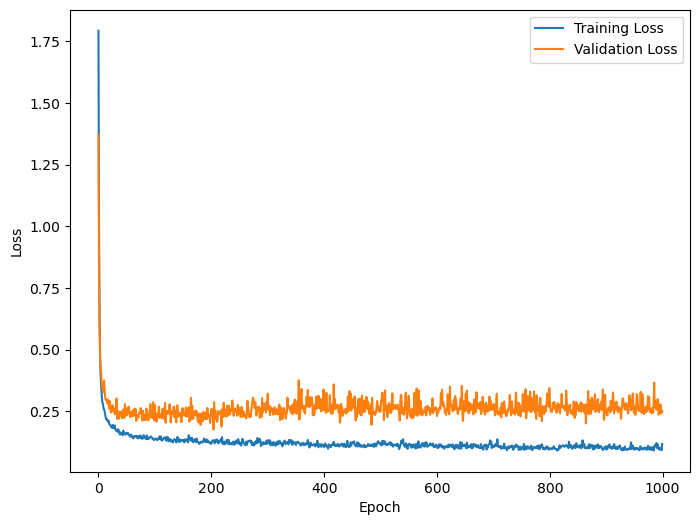

In [138]:
import matplotlib.pyplot as plt
# Plotting the loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### Evaluate Model

In [122]:
from sklearn.metrics import classification_report

# Evaluate the model
# Convert data to DataLoader for test set
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model.eval()

predicted_labels, actual_labels = utils.model_predict(test_loader, model, encoder)
# Calculate and print the classification report
report = classification_report(actual_labels, predicted_labels)
print(report)

Test accuracy: 94.48%
                        precision    recall  f1-score   support

                 Climb       0.99      0.98      0.98       134
                Cruise       0.96      0.98      0.97       137
               Descent       0.99      1.00      1.00       149
                 Hover       0.75      0.75      0.75         4
Hover In Ground Effect       0.75      0.96      0.84        70
      LandingOrTakeOff       1.00      0.98      0.99        98
              Standing       0.40      0.08      0.14        24

              accuracy                           0.94       616
             macro avg       0.84      0.82      0.81       616
          weighted avg       0.93      0.94      0.93       616



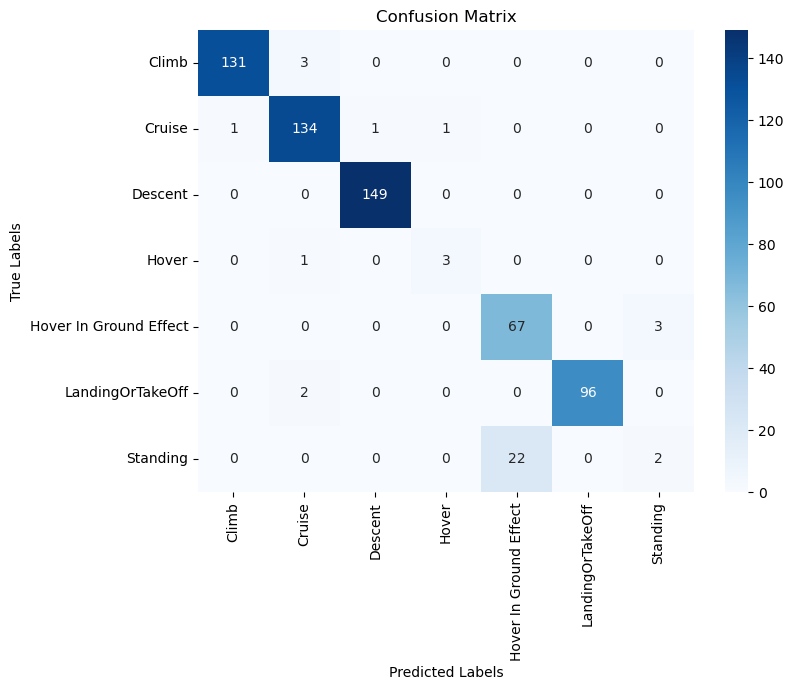

In [161]:
from sklearn.metrics import confusion_matrix
import utils

utils.plot_confusion_matrix_heatmap(actual_labels, predicted_labels)

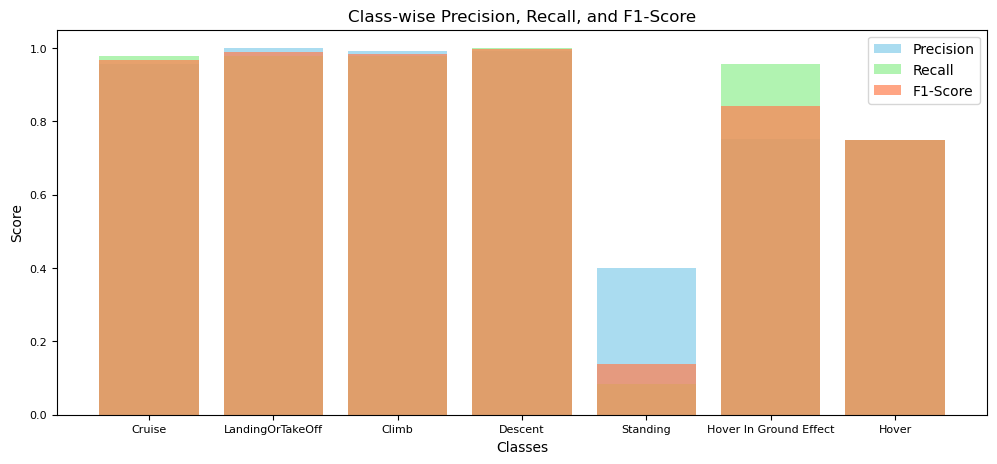

In [159]:
from sklearn.metrics import precision_recall_fscore_support
import utils
import importlib
importlib.reload(utils)

unique_labels = list(set(actual_labels))
precision, recall, f1_score, _ = precision_recall_fscore_support(actual_labels, predicted_labels,
                                                                 average=None, labels=unique_labels)
utils.plot_class_wise_prf(unique_labels, precision, recall, f1_score)

#### Test with second data set

In [111]:
import utils

test_csv_directory = 'data/test_data'
test_df = utils.load_data_from_dir(test_csv_directory)

reading file data/test_data\SimData_2022.03.31_09.14.40.csv
reading file data/test_data\SimData_2022.03.31_09.38.42.csv
reading file data/test_data\SimData_2022.03.31_10.57.22.csv
reading file data/test_data\SimData_2022.03.31_12.57.00.csv
reading file data/test_data\SimData_2022.03.31_13.47.24.csv
reading file data/test_data\SimData_2022.03.31_15.21.35.csv
reading file data/test_data\SimData_2022.03.31_16.51.42.csv
reading file data/test_data\SimData_2023.01.12_09.00.50.csv
reading file data/test_data\SimData_2023.01.12_09.28.10.csv
reading file data/test_data\SimData_2023.01.12_10.41.08.csv
reading file data/test_data\SimData_2023.01.12_10.45.38.csv
reading file data/test_data\SimData_2023.01.12_12.36.17.csv
reading file data/test_data\SimData_2023.01.12_12.36.37.csv
reading file data/test_data\SimData_2023.01.12_12.37.48.csv
reading file data/test_data\SimData_2023.01.12_12.43.44.csv
reading file data/test_data\SimData_2023.01.12_12.48.49.csv
reading file data/test_data\SimData_2023

In [112]:
test_formatted_df = utils.format_data(test_df)
test_formatted_df['Phase'] = test_formatted_df.apply(lambda row: identify_phase(row['Vert. Speed'], row['Groundspeed'], row['Altitude(AGL)']), axis=1)
print('number of test data rows', len(test_formatted_df))
test_formatted_df.head(10)

number of test data rows 2838392


,Vert. Speed,Groundspeed,Altitude(AGL),DateTime,Phase
0,1774.112,90.055,1079.71,2022-03-31 13:14:40.712,Climb
1,1773.997,90.063,1080.13,2022-03-31 13:14:40.732,Climb
2,1773.840,90.075,1080.70,2022-03-31 13:14:40.750,Climb
3,1773.695,90.086,1081.24,2022-03-31 13:14:40.768,Climb
4,1773.561,90.096,1081.76,2022-03-31 13:14:40.785,Climb
5,1773.433,90.106,1082.26,2022-03-31 13:14:40.801,Climb
6,1773.311,90.116,1082.74,2022-03-31 13:14:40.819,Climb
7,1773.079,90.135,1083.71,2022-03-31 13:14:40.849,Climb
8,1772.976,90.144,1084.15,2022-03-31 13:14:40.868,Climb
9,1772.750,90.165,1085.17,2022-03-31 13:14:40.899,Climb


#### Create sequences from test data

In [113]:
X_test2, y_test2 = utils.create_sliding_window_sequences(test_formatted_df, sequence_length, step_size)

In [114]:
import numpy as np
# use same encoder. created a new encoder by accident and that caused issues vey difficult to debug
# cuda library will complain with GPU on with no direct association of underlying label mismatch
y_test2 = encoder.transform(np.array(y_test2))
X_test2_torch, y_test2_torch = utils.torch_input_output(X_test2, y_test2, device)

In [140]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

test_data2 = TensorDataset(X_test2_torch, y_test2_torch)
test_loader2 = DataLoader(test_data2, batch_size=32, shuffle=False)

model.eval()

predicted_labels2, actual_labels2 = utils.model_predict(test_loader2, model, encoder)
# Calculate and print the classification report
report2 = classification_report(actual_labels2, predicted_labels2)
print(report2)

Test accuracy: 90.08%
                        precision    recall  f1-score   support

                 Climb       0.99      0.98      0.99       640
                Cruise       0.94      0.98      0.96       560
               Descent       0.99      0.99      0.99       763
                 Hover       0.00      0.00      0.00        13
Hover In Ground Effect       0.59      0.96      0.73       325
      LandingOrTakeOff       0.98      0.99      0.98       315
              Standing       0.11      0.00      0.01       218

              accuracy                           0.90      2834
             macro avg       0.66      0.70      0.67      2834
          weighted avg       0.86      0.90      0.87      2834



D:\yaraf\softwares\miniconda3\envs\daen690-win\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\yaraf\softwares\miniconda3\envs\daen690-win\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\yaraf\softwares\miniconda3\envs\daen690-win\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

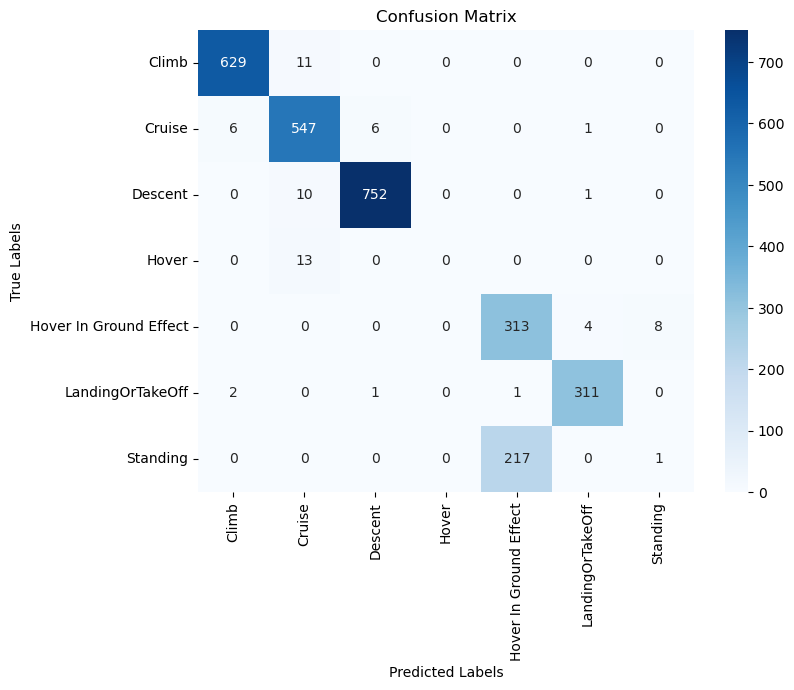

In [162]:
import utils

utils.plot_confusion_matrix_heatmap(actual_labels2, predicted_labels2)

D:\yaraf\softwares\miniconda3\envs\daen690-win\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


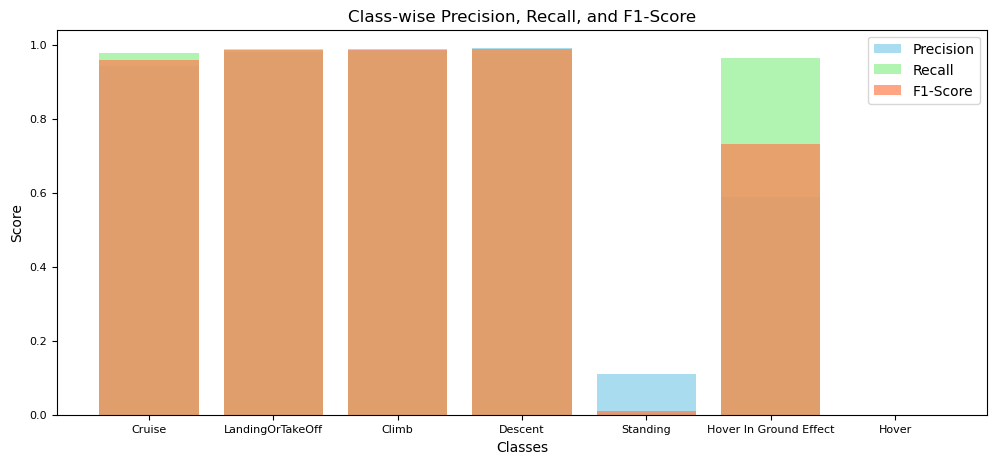

In [163]:
from sklearn.metrics import precision_recall_fscore_support
import utils

unique_labels2 = list(set(actual_labels2))
precision2, recall2, f1_score2, _ = precision_recall_fscore_support(actual_labels2, predicted_labels2,
                                                                 average=None, labels=unique_labels2)
utils.plot_class_wise_prf(unique_labels2, precision2, recall2, f1_score2)